In [1]:
import numpy as np
import pandas as pd
# import cv2
import os
import geopandas as gpd
from geopandas import datasets, GeoDataFrame, read_file
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

ModuleNotFoundError: No module named 'geopandas'

In [2]:
def count(TSAv):
    temp_count = 0
    apear_ind = []
    counts = []
    for i in range(len(TSAv)):
        if (TSAv[i] == True):
            temp_count += 1
        else:
            if (i > 0) & (TSAv[i - 1] == True):
                apear_ind.append(i - temp_count)
                counts.append(temp_count)
                temp_count = 0
                counts.append(0)
            else:
                counts.append(0)
        if (i == len(TSAv) - 1) & (temp_count != 0):
            apear_ind.append(i - temp_count + 1)
            counts.append(temp_count)
    counts = np.array(counts)
    counts = counts[counts > 0]
    return np.array(counts), np.array(apear_ind)

In [26]:
poly = gpd.read_file(r'D:\LiDAR_Data\ParkingData\ParkingSpace\ParkingSpaceLawrence.shp')

In [27]:
f_path = r'D:\LiDAR_Data\ParkingData\Lawrence\ProcessedTrajs'
lis_f = os.listdir(f_path)

In [28]:
date = []
for i in range(len(lis_f)):
    year,month,day,hour,mint = int(lis_f[i].split('-')[0]),int(lis_f[i].split('-')[1]),int(lis_f[i].split('-')[2]),int(lis_f[i].split('-')[3]),int(lis_f[i].split('-')[4])
    date.append(pd.Timestamp(year=year,month = month,day = day, hour = hour,minute=mint))

In [29]:
sorted_lis_f = np.array(lis_f)[pd.Series(date).argsort()]

In [30]:
dic = {}
for i in range(len(poly)):
    dic[i] = []

In [42]:
sorted_lis_f[26]

'2021-12-19-0-30-0.csv.csv'

In [35]:
for ind_h in range(48):
    test = pd.read_csv(os.path.join(f_path,sorted_lis_f[25 + ind_h]))
    gdf = geopandas.GeoDataFrame(
    test, geometry=geopandas.points_from_xy(test.Lon, test.Lat))
    gdf.crs = 'EPSG:4326'
    join_left_df = gdf.sjoin(poly, how="left")
    join_left_df = join_left_df.dropna(axis = 0)
    for parking_space_ind,g in join_left_df.groupby('index_right'):
        dic[int(parking_space_ind)].append(g)

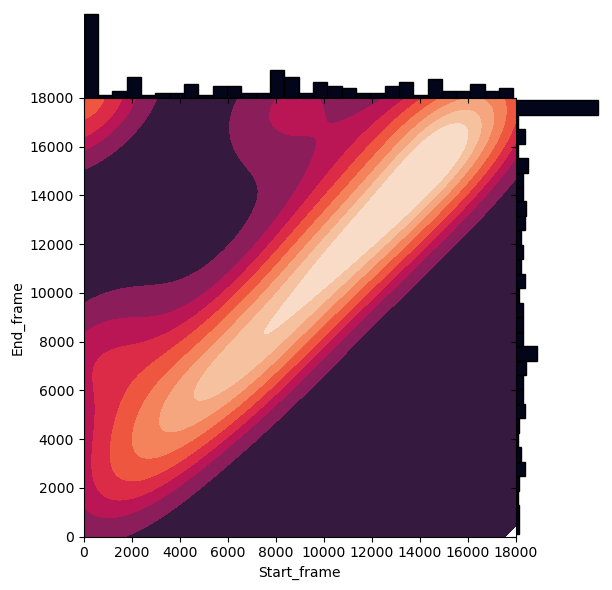

In [40]:
data = dic[1][1]
SEpairs,counts = np.unique(np.array(data.loc[:,['Start_frame','End_frame']]),axis = 0,return_counts=True)
EventScanFreq = counts/counts.sum()
ind_valid = np.where(EventScanFreq > 0.1)[0]
extracted_ts = []
for i in ind_valid:
    extracted_ts.append(SEpairs[i])
g = sns.JointGrid(data=data, x="Start_frame", y="End_frame", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((0, 18000), (0, 18000)),
             thresh=0, levels=10, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=30)

In [52]:
sorted_lis_f[34]

'2021-12-19-4-30-0.csv.csv'

In [88]:
test = pd.read_csv(os.path.join(f_path,sorted_lis_f[34]))
gdf = geopandas.GeoDataFrame(
test, geometry=geopandas.points_from_xy(test.Longitude, test.Latitude))
gdf.crs = poly.crs
join_left_df = gdf.sjoin(poly, how="left")
join_left_df = join_left_df.dropna(axis = 0)


In [92]:
join_left_df.loc[join_left_df.index_right == 8]

,Start_ts,End_ts,LaserBeamID,Lon,Lat,Elev,X,Y,Z,Start_frame,End_frame,Longitude,Latitude,Elevation,geometry,index_right,Shape_Leng,Shape_Area,ParkingTyp,Curbside
139,2021-12-19 23:30:00,2021-12-19 23:59:50,4186.0,-119.809886,39.518563,1328.201139,13.09263,-6.728698,-2.944113,0.0,17900.0,-119.809584,39.518248,1367.959023,POINT (-119.80958 39.51825),8.0,0.000146,1.167517e-09,1.0,1.0
150,2021-12-19 23:30:00,2021-12-19 23:32:40,4219.0,-119.809888,39.518574,1328.090424,12.09885,-8.099474,-2.911950,0.0,1600.0,-119.809591,39.518262,1367.959021,POINT (-119.80959 39.51826),8.0,0.000146,1.167517e-09,1.0,1.0


In [90]:
Parking_indicator = np.full((len(poly),18000*48),False)
for ind_h in range(48):
    test = pd.read_csv(os.path.join(f_path,sorted_lis_f[25 + ind_h]))
    gdf = geopandas.GeoDataFrame(
    test, geometry=geopandas.points_from_xy(test.Longitude, test.Latitude))
    gdf.crs = 'EPSG:4326'
    join_left_df = gdf.sjoin(poly, how="left")
    join_left_df = join_left_df.dropna(axis = 0)
    for parking_space_ind,g in join_left_df.groupby('index_right'):
        SEpairs,counts = np.unique(np.array(g.loc[:,['Start_frame','End_frame']]),axis = 0,return_counts=True)
        EventScanFreq = counts/counts.sum()
        ind_valid = np.where((EventScanFreq > 0.1)&(counts > 2))[0]
        extracted_ts = []
        for i in ind_valid:
            extracted_ts.append(SEpairs[i])
        
        for i in range(len(extracted_ts)):
            start,end = extracted_ts[i].astype(int) 
            Parking_indicator[int(parking_space_ind),int(ind_h*18000+start):int(ind_h*18000+end+100)] = True

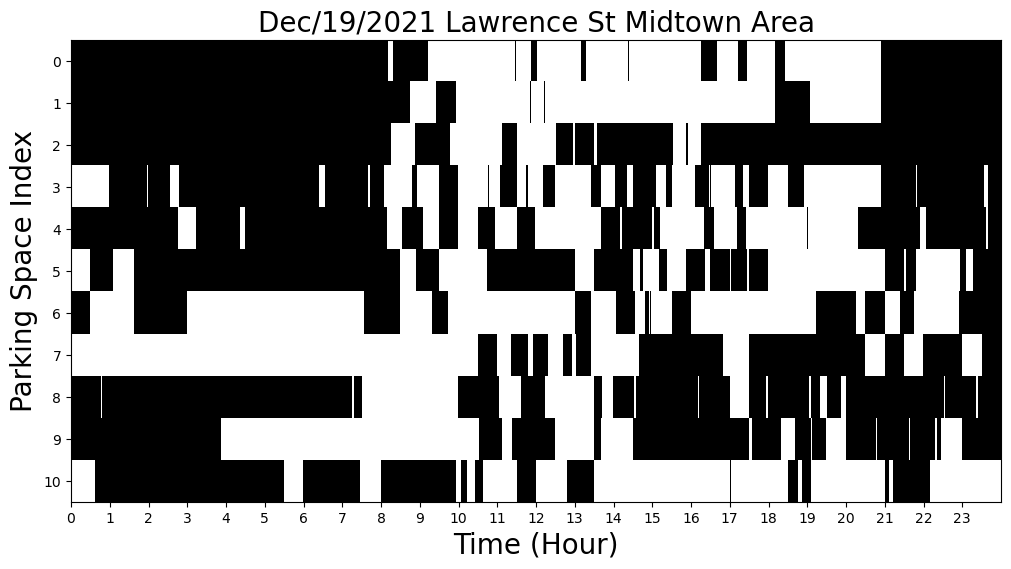

In [94]:
plt.figure(figsize=(12,6))
plt.title('Dec/19/2021 Lawrence St Midtown Area',fontsize = 20)
plt.imshow(Parking_indicator,aspect='auto',cmap = 'gray',interpolation = 'none')
plt.xticks(np.arange(0,36000*24,36000),np.arange(0,24))
plt.yticks(np.arange(0,len(poly)))
plt.xlabel('Time (Hour)',fontsize = 20)
plt.ylabel('Parking Space Index',fontsize = 20)
plt.show()

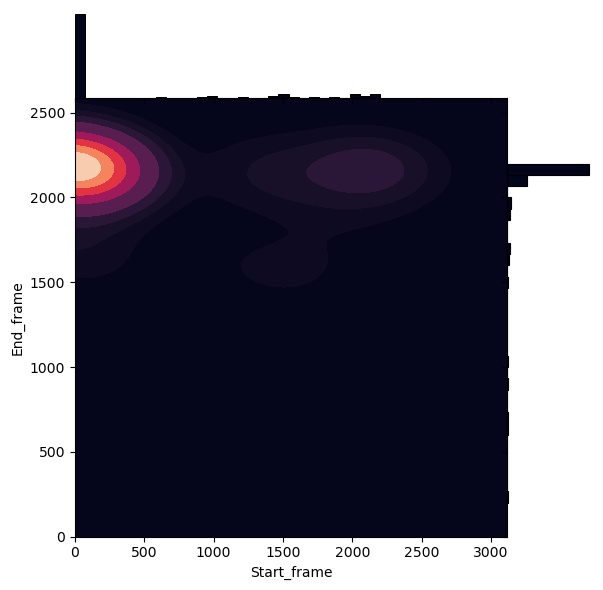

In [188]:
g = sns.JointGrid(data=dic[2][17], x="Start_frame", y="End_frame", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, clip=((0, 18000), (0, 18000)),
             thresh=0, levels=10, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=30)

In [99]:
SEpairs,counts = np.unique(np.array(dic[2][17].loc[:,['Start_frame','End_frame']]),axis = 0,return_counts=True)
EventScanFreq = counts/counts.sum()
ind_valid = np.where(EventScanFreq > 0.1)[0]
extracted_ts = []
for i in ind_valid:
    extracted_ts.append(SEpairs[i])
Labels = np.full(18000,False)
for i in range(len(extracted_ts)):
    start,end = extracted_ts[i].astype(int)
    Labels[start:end+1] = True 
counts,appears = count(Labels)   